In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [2]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 12

# Training 수
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

# Data Information in DataFrame

In [3]:
# 디렉토리 경로 설정 필요
CurrentDirectory = "./"

TRAIN_DF = pd.read_csv("TRAIN.csv")
TEST_DF  = pd.read_csv("TEST.csv" )

In [4]:
TRAIN_DF['sex'] = pd.get_dummies(TRAIN_DF['sex'])['female'].astype('float')
TEST_DF ['sex'] = pd.get_dummies( TEST_DF['sex'])['female'].astype('float')

In [5]:
TRAIN_DF.head()

,filename,lesion_id,image_id,dx,dx_type,age,sex,localization
0,akiec/ISIC_0024372.jpg,HAM_0005389,ISIC_0024372,akiec,histo,70,0.0,lower extremity
1,akiec/ISIC_0024418.jpg,HAM_0003380,ISIC_0024418,akiec,histo,75,1.0,lower extremity
2,akiec/ISIC_0024450.jpg,HAM_0005505,ISIC_0024450,akiec,histo,50,0.0,upper extremity
3,akiec/ISIC_0024463.jpg,HAM_0004568,ISIC_0024463,akiec,histo,50,0.0,upper extremity
4,akiec/ISIC_0024468.jpg,HAM_0006301,ISIC_0024468,akiec,histo,75,0.0,neck


In [6]:
TEST_DF.head()

,filename,lesion_id,image_id,dx,dx_type,age,sex,localization
0,akiec/ISIC_0024329.jpg,HAM_0002954,ISIC_0024329,akiec,histo,75,1.0,lower extremity
1,akiec/ISIC_0024707.jpg,HAM_0005448,ISIC_0024707,akiec,histo,60,0.0,face
2,akiec/ISIC_0024710.jpg,HAM_0004609,ISIC_0024710,akiec,histo,75,0.0,back
3,akiec/ISIC_0025247.jpg,HAM_0005231,ISIC_0025247,akiec,histo,70,0.0,lower extremity
4,akiec/ISIC_0025368.jpg,HAM_0004472,ISIC_0025368,akiec,histo,40,1.0,face


# Custom Generator with flow from directory

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, Generator, dataFrame, directory, x_col, y_col, target_size, batch_size, shuffle, class_mode, subset=None):
        self.GeneratorObject = Generator.flow_from_dataframe(
                dataframe=dataFrame,
                directory = directory,
                x_col=x_col,
                y_col=y_col,
                target_size = target_size,
                batch_size = batch_size,
                shuffle = False,
                class_mode = class_mode,
                subset = subset)
        self.n = self.GeneratorObject.n
        self.dataframe = dataFrame
        self.batch_size = batch_size
        self.classes = self.GeneratorObject.classes
        self.filenames = self.GeneratorObject.filenames
        
    def __len__(self):
        return self.GeneratorObject.__len__()
    
    def getBatchIndex(self):
        return self.GeneratorObject.batch_index

    def __getitem__(self, index):
        Images, Labels = self.GeneratorObject.__getitem__(index)
        curBatchIDX = index * batch_size
        X = self.dataframe.iloc[curBatchIDX : (curBatchIDX + Images.shape[0]), : ]
        return [Images, np.array(X[['age', 'sex']])], Labels
    
    def next(self):
        curBatchIDX = self.GeneratorObject.batch_index * self.batch_size
        Images, Labels = self.GeneratorObject.next()
        X = self.dataframe.iloc[curBatchIDX : (curBatchIDX + Images.shape[0]), : ]
        return [Images, X[['age', 'sex']]], Labels
    
    def on_epoch_end(self):
        return self.GeneratorObject.on_epoch_end

In [8]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

In [9]:
TRAIN_GENERATOR = DataGenerator(DATAGEN_TRAIN,
    dataFrame=TRAIN_DF,
    directory='TRAIN',
    target_size = (224, 224),
    batch_size = 12,
    x_col="filename",
    y_col="dx",
    class_mode='categorical',
    shuffle = True,
    subset='training')

Found 719 validated image filenames belonging to 3 classes.


In [10]:
VALID_GENERATOR = DataGenerator(DATAGEN_TRAIN,
    dataFrame=TRAIN_DF,
    directory='TRAIN',
    target_size = (224, 224),
    batch_size = 12,
    x_col="filename",
    y_col="dx",
    class_mode='categorical',
    shuffle = True,
    subset='validation')

Found 79 validated image filenames belonging to 3 classes.


In [11]:
TEST_GENERATOR = DataGenerator(DATAGEN_TEST,
    dataFrame=TEST_DF,
    directory='TEST',
    target_size = (224, 224),
    batch_size = 12,
    x_col="filename",
    y_col="dx",
    class_mode='categorical',
    shuffle = True,
    subset='validation')

Found 10 validated image filenames belonging to 3 classes.


In [12]:
res = TRAIN_GENERATOR.__getitem__(0)

In [13]:
res[0][0].shape

(12, 224, 224, 3)

In [14]:
print(res[0][1].shape)

(12, 2)


In [15]:
res[1].shape

(12, 3)

In [16]:
BaseModel = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
CNN = GlobalAveragePooling2D()(BaseModel.output)

InputB = tf.keras.layers.Input(shape=(2,), name='inputB')
OutputB = Dense(2, activation='relu')(InputB)

Merged = tf.keras.layers.Concatenate(axis=1)([CNN, OutputB])
Output = Dense(3, activation='softmax')(Merged)

DeepLearning = tf.keras.Model(inputs=[BaseModel.input, InputB], outputs=Output)

In [17]:
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
) # 나이를, MSE

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


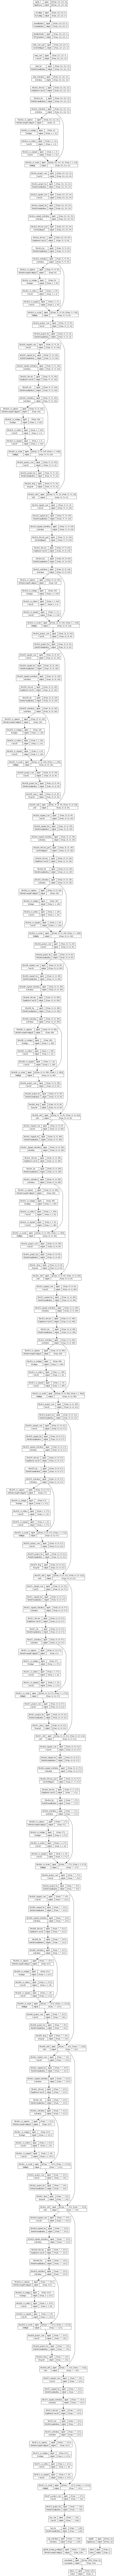

In [18]:
tf.keras.utils.plot_model(DeepLearning, show_shapes=True)

In [19]:
DeepLearning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

In [20]:
DeepLearning.fit(TRAIN_GENERATOR,         
        epochs=1,
        validation_data=VALID_GENERATOR)

60/60 [==============================] - 216s 3s/step - loss: 1.1582 - acc: 0.2949 - val_loss: 1.0124 - val_acc: 0.0000e+00
